# Using XyloSamna and XyloMonitor to deploy a model on XyloAudio 3 HDK

## Common steps for both Accelerated and Real-time mode

### Loading the trained model

In this example, we use a trained model for a binary classification task: detecting a baby's cry. The model is composed of 16 input channels, three layers of LIF (Leak Integrate & Fire) neurons, and one single output neuron.  

In [1]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch
import warnings
warnings.filterwarnings("ignore")

ckpt = 'model_sample/to_deploy_inXylo.json'

#  trained model architecture parameters
arch_params = {'n_classes': 1,
'n_channels': 16,
'size_hidden_layers':[63, 63, 63],
'time_constants_per_layer':[3,7,7],
'tau_syn_base': 0.02,
'tau_mem': 0.02,
'tau_syn_out': 0.02,
'neuron_model': LIFTorch,
'dt': 0.00994,
'output': 'vmem'}

# Number of input channels
Nin = 16

# instantiating the model backbone and loading trained checkpoint
model = SynNet(** arch_params)
model.load(ckpt)

WARNING    /home/vleite/SynSense/rockpool/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
 [py.warnings]
WARNING    /home/vleite/SynSense/rockpool/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
 [py.warnings]


### Mapping, quantizing and building the configuration object for XyloAudio 3 HDK 

In [2]:
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper
import rockpool.transform.quantize_methods as q

# getting the model specifications using the mapper function
spec = mapper(model.as_graph(), weight_dtype='float', threshold_dtype='float', dash_dtype='float')
# quantizing the model
spec.update(q.channel_quantize(**spec))

xylo_conf, is_valid, msg = config_from_specification(**spec)

## Using XyloSamna in Accelerated time mode
In *Accelerated time* mode we can give a specific input to XyloAudio that will be processed as quickly as possible, while allowing the monitoring of the internal network state.
This mode is ideal for benchmarking and validating models.

In *Accelerated time*, the input has to be a list of spike events ordered by timestep. 

### Creating XyloSamna: API to interact with HDK in *Accelerated time* mode

**Note: We need an AudioXylo 3 connected to run this step**

In [3]:
from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as hdu
from rockpool.devices.xylo.syns65302 import XyloSamna
import samna

# getting the connected devices and choosing xyloa3 board
xylo_nodes = hdu.find_xylo_a3_boards()
xa3 = xylo_nodes[0]
# changing the default operation mode
xylo_conf.operation_mode = samna.xyloAudio3.OperationMode.AcceleratedTime
# instantiating XyloSamna, make sure your dt corresponds to the dt of your input data
Xmod = XyloSamna(device=xa3, config=xylo_conf, dt = 0.01, record = True)

### Feeding the test sample to XyloSamna
- Please see [this tutorial](AFESim3_as_transform.ipynb) as an example on how to convert audio signals into spike trains.

In [4]:
import numpy as np

test_sample = np.load('afesim_sample/AFESimExternalSample.npy', allow_pickle=True)
out, _, rec = Xmod(test_sample)
print(f'cry detected: {np.sum(out)>0}')  


cry detected: True


### Analyzing recorded states

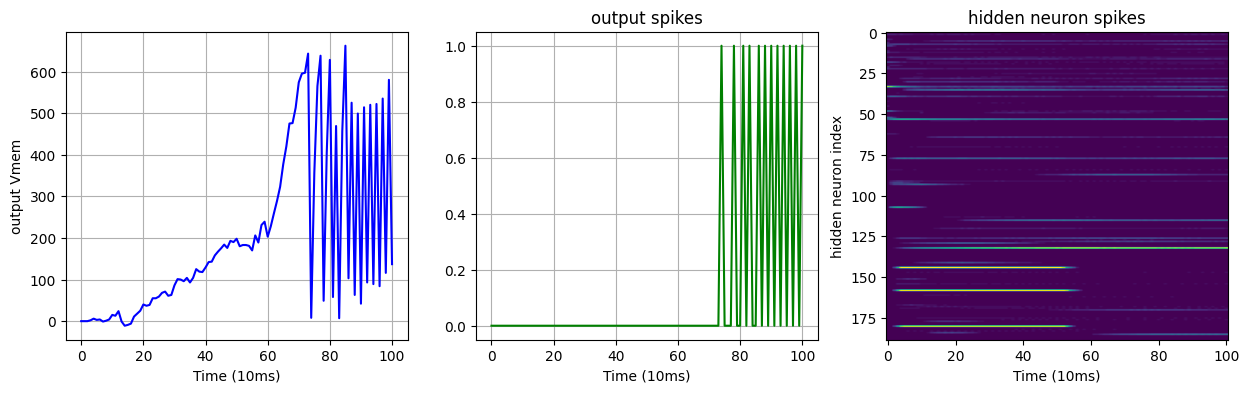

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(131); plt.plot(rec['Vmem_out'], 'b'); plt.grid(True); plt.xlabel('Time (10ms)'); plt.ylabel('output Vmem'); 
plt.subplot(132); plt.plot(out, 'g');plt.grid(True); plt.xlabel('Time (10ms)'); plt.title('output spikes'); 
plt.subplot(133); plt.imshow(rec['Spikes'].T, aspect='auto'); plt.xlabel('Time (10ms)'); plt.ylabel('hidden neuron index'); plt.title('hidden neuron spikes');


## Using XyloMonitor in Real Time mode
In *Real-time* mode, XyloAudio 3 continuously processes events as they are received.
Events are received directly from one of the onboard microphones instead of event-based input.

In this mode, the chip operates autonomously, collecting inputs and processing them. Once the processing is done, XyloAudio 3 outputs all generated spike events. It is not possible to interact with the chip during this period. Thus, the collection of internal neuron states is not permitted.

### Creating XyloMonitor: API to interact with HDK in *Real-time* mode

In [6]:
import samna
from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as hdu
from rockpool.devices.xylo.syns65302 import XyloMonitor

# getting the connected devices and choosing xyloa3 board
xylo_nodes = hdu.find_xylo_a3_boards()
xa3 = xylo_nodes[0]

# changing operation mode
xylo_conf.operation_mode = samna.xyloAudio3.OperationMode.RealTime      
xylo_monitor  = XyloMonitor(device=xa3, config=xylo_conf, dt = 0.01, output_mode='Spike', dn_enable = True, digital_microphone=True)
              

[2024-10-31 05:53:08.985] [XyloAudio3] [warning] Requested SAER clock frequency 12 could not be achieved, used 11.999999040000077 instead
[2024-10-31 05:53:08.985] [XyloAudio3] [warning] Requested SADC clock frequency 12 could not be achieved, used 11.999999040000077 instead


In [7]:
from scipy.io import wavfile
!pip install simpleaudio
import simpleaudio as sa
import numpy as np

def get_wave_object(test_file): 
    sample_rate, data = wavfile.read(test_file)
  
    duration = int(len(data)/sample_rate) # in seconds
    n = data.ndim

    if data.dtype == np.int8:
        bytes_per_sample = 1
    elif data.dtype == np.int16:
        bytes_per_sample = 2
    elif data.dtype == np.float32:
        bytes_per_sample = 4   
    else:
        raise ValueError("recorded audio should have 1 or 2 bytes per sample!")

    wave_obj = sa.WaveObject(
        audio_data= data,
        num_channels=data.ndim,
        bytes_per_sample=bytes_per_sample,
        sample_rate=sample_rate
    )  

    return duration,wave_obj   

Defaulting to user installation because normal site-packages is not writeable


In [8]:
test_audio = 'audio_sample/cry_sample_3sec.wav'
duration, wave_obj = get_wave_object(test_audio)
dt = 0.01
T = int(duration/dt) # timesteps

play_obj = wave_obj.play()
out, state, rec = xylo_monitor.evolve(input_data=np.zeros([T, Nin]))
play_obj.wait_done()

print(f'cry detected: {np.sum(out)>0}')  


cry detected: True
